# 0. Setup the Environment

In [1]:
%load_ext autoreload
%autoreload 2
%cd /home/jx8fh/Projects/LaMoD
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from modules.data import check_dict

/sfs/qumulo/qhome/jx8fh/Projects/LaMoD


In [11]:
!nvidia-smi

Tue Jul 23 09:52:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:07:00.0 Off |                    0 |
| N/A   40C    P0             74W /  400W |   51737MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
# setup device
import os
import torch
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 1. Load Config

In [12]:
import json
config_filename = 'configs/ours-pretrain-motion-decoder.json'
config = json.load(open(config_filename, 'r'))

# 2. Load Data

In [5]:
# # Load raw data
# train_data = np.load(config['data']['train'], allow_pickle=True).tolist()
# val_data = np.load(config['data']['val'], allow_pickle=True).tolist()
# test_data = np.load(config['data']['test'], allow_pickle=True).tolist()

# # Build datasets
# from modules.dataset import VideoVolDataset
# train_dataset = VideoVolDataset(train_data, config['datasets']['train'])
# val_dataset = VideoVolDataset(val_data, config['datasets']['val'])
# test_dataset = VideoVolDataset(test_data, config['datasets']['test'])

# datasets = {
#     'train': train_dataset,
#     'val': val_dataset,
#     'test': test_dataset
# }
from modules.dataset import VideoVolDataset
datasets = {}
for dataset_name in ['train', 'val', 'test']:
    # Load raw data
    curr_data = np.load(config['data'][dataset_name], allow_pickle=True).tolist()
    # Build dataset
    curr_dataset = VideoVolDataset(curr_data, config['datasets'][dataset_name])
    # Add to datasets dict
    datasets[dataset_name] = curr_dataset

In [6]:
check_dict(datasets['train'].data[0])

ori_n_frames                                                 22                  
augmented                                                    False               
DENSE_slice_mat_filename                                     /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/00_Circle_V10_auto.1_ROI.1.mat
DENSE_slice_location                                         61.970369270087     
subject_id                                                   00_Circle_V10-DENSE 
slice_idx                                                    0                   
slice_full_id                                                00_Circle_V10-0     
full_name                                                    00_Circle_V10-DENSE_0
DENSE_disp                                                   (2, 40, 48, 48)     
myo_masks                                                    (1, 40, 128, 128)   


In [7]:
check_dict(datasets['train'][0])

src                                                          (1, 39, 128, 128)   
tar                                                          (1, 39, 128, 128)   
DENSE_disp                                                   (2, 39, 48, 48)     
ori_n_frames                                                 22                  
augmented                                                    False               
DENSE_slice_mat_filename                                     /p/miauva/data/Jerry/medical-images/Cardiac-FromKen/Yu-DENSE-data/00_Circle_V10_auto.1_ROI.1.mat
DENSE_slice_location                                         61.970369270087     
subject_id                                                   00_Circle_V10-DENSE 
slice_idx                                                    0                   
slice_full_id                                                00_Circle_V10-0     
full_name                                                    00_Circle_V10-DENSE_0


# 3. Build Model

In [13]:
from models import build_model
networks = {}
for model_name, model_config in config['networks'].items():
    networks[model_name] = build_model(model_config)
    networks[model_name] = networks[model_name].to(device)

Skip connect: False
Loading pretrained model from /home/jx8fh/Projects/LaMoD/checkpoints/registration.pth
ignorekwargs: {'type': 'DiffusionDecoder', 'drouput': 0.3, 'load_pretrained': False, 'pretrained_model_path': ''}
Decoder tanh_out:  False
Decoder: give_pre_end=False, tanh_out=False, out_scaling_factor=1
Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels


# 4. Build Trainer

In [14]:
from modules.trainer import build_trainer
# For debug: use small epoch number and batch size
config['training']['epochs'] = 10
config['training']['batch_size'] = 12
trainer = build_trainer(config['training'], device, config)

# 5. Training

In [15]:
exp_dict, trained_models, wandb_experiment = trainer.train(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    use_tensorboard=False,
    tensorboard_log_dir='tensorboard',
    use_wandb=False)

Loss DENSE_disp_reconstruction_MSE is disabled
Loss DENSE_disp_reconstruction_EPE is disabled
motion_regression lr_scheduler: <torch.optim.lr_scheduler.StepLR object at 0x7fd714a234f0>


45it [01:50,  2.45s/it]00:00<?, ?it/s]
9it [00:08,  1.11it/s].634e-01:   0%|          | 0/10 [01:51<?, ?it/s]
Epoch 0 | Train Loss 1.634e-01:  10%|█         | 1/10 [01:59<17:58, 119.82s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.18216181364324358,
    "train/total_loss": 0.7520815379089779,
    "train/DENSE_disp_reconstruction_error": 0.5699197242657343,
    "val/DENSE_disp_reconstruction_L1": 0.15329990370406044,
    "val/total_loss": 0.5657837928997146,
    "val/DENSE_disp_reconstruction_error": 0.41248388919565415
}


45it [01:48,  2.42s/it]
9it [00:10,  1.14s/it].449e-01:  10%|█         | 1/10 [03:50<17:58, 119.82s/it]
Epoch 1 | Train Loss 1.449e-01:  20%|██        | 2/10 [04:00<16:01, 120.22s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.15197140243318347,
    "train/total_loss": 0.5532827112409804,
    "train/DENSE_disp_reconstruction_error": 0.4013113088077969,
    "val/DENSE_disp_reconstruction_L1": 0.1448371691836251,
    "val/total_loss": 0.5146034359931946,
    "val/DENSE_disp_reconstruction_error": 0.3697662668095695
}


45it [01:49,  2.42s/it]
9it [00:08,  1.04it/s].450e-01:  20%|██        | 2/10 [05:50<16:01, 120.22s/it]
Epoch 2 | Train Loss 1.450e-01:  30%|███       | 3/10 [05:59<13:57, 119.70s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.1456432181927893,
    "train/total_loss": 0.5157723458276855,
    "train/DENSE_disp_reconstruction_error": 0.3701291276348962,
    "val/DENSE_disp_reconstruction_L1": 0.13898652543624243,
    "val/total_loss": 0.4795325837201542,
    "val/DENSE_disp_reconstruction_error": 0.3405460582839118
}


45it [01:49,  2.43s/it]
9it [00:09,  1.06s/it].708e-01:  30%|███       | 3/10 [07:49<13:57, 119.70s/it]
Epoch 3 | Train Loss 1.708e-01:  40%|████      | 4/10 [07:59<11:58, 119.82s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.13843366785181893,
    "train/total_loss": 0.4739954426884651,
    "train/DENSE_disp_reconstruction_error": 0.3355617748366462,
    "val/DENSE_disp_reconstruction_L1": 0.13655291580491596,
    "val/total_loss": 0.4620053561197387,
    "val/DENSE_disp_reconstruction_error": 0.32545244031482273
}


45it [01:48,  2.42s/it]
9it [00:07,  1.17it/s].445e-01:  40%|████      | 4/10 [09:49<11:58, 119.82s/it]
Epoch 4 | Train Loss 1.445e-01:  50%|█████     | 5/10 [09:57<09:55, 119.14s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.13566002233160868,
    "train/total_loss": 0.4602533510989613,
    "train/DENSE_disp_reconstruction_error": 0.32459332876735264,
    "val/DENSE_disp_reconstruction_L1": 0.13603326429923376,
    "val/total_loss": 0.45698873450358707,
    "val/DENSE_disp_reconstruction_error": 0.32095547020435333
}


45it [01:48,  2.42s/it]
9it [00:07,  1.20it/s].051e-01:  50%|█████     | 5/10 [11:47<09:55, 119.14s/it]
Epoch 5 | Train Loss 1.051e-01:  60%|██████    | 6/10 [11:55<07:54, 118.65s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.13534999787807464,
    "train/total_loss": 0.4588176495499081,
    "train/DENSE_disp_reconstruction_error": 0.32346765167183344,
    "val/DENSE_disp_reconstruction_L1": 0.1342153838939137,
    "val/total_loss": 0.45322735028134453,
    "val/DENSE_disp_reconstruction_error": 0.31901196638743085
}


45it [01:49,  2.42s/it]
9it [00:08,  1.01it/s].441e-01:  60%|██████    | 6/10 [13:45<07:54, 118.65s/it]
Epoch 6 | Train Loss 1.441e-01:  70%|███████   | 7/10 [13:54<05:56, 118.85s/it]

{
    "train/DENSE_disp_reconstruction_L1": 0.13538112706608244,
    "train/total_loss": 0.4565434286991755,
    "train/DENSE_disp_reconstruction_error": 0.3211623016330931,
    "val/DENSE_disp_reconstruction_L1": 0.13541454739040798,
    "val/total_loss": 0.45379623770713806,
    "val/DENSE_disp_reconstruction_error": 0.3183816903167301
}
Epochs without improvement: 1 / 30


27it [01:07,  2.49s/it]
Epoch 6 | Train Loss 1.441e-01:  70%|███████   | 7/10 [15:01<06:26, 128.79s/it]

KeyboardInterrupt at epoch 7


# 6. Test

In [16]:
# test model on training set
train_pred, train_performance_dict, _ = trainer.test(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    target_dataset='train',
    mode='test')

test_loss_dict:  {'train/DENSE_disp_reconstruction_L1': 0.1331221786638101, 'train/total_loss': 0.4460426909228166, 'train/DENSE_disp_reconstruction_error': 0.3129205122590065}


In [17]:
# test model
test_pred, test_performance_dict, _ = trainer.test(
    models=networks, 
    datasets=datasets, 
    trainer_config=config['training'], 
    full_config=config, 
    device=device,
    target_dataset='test',
    mode='test')

test_loss_dict:  {'test/DENSE_disp_reconstruction_L1': 0.16148888071378073, 'test/total_loss': 0.5373277150922351, 'test/DENSE_disp_reconstruction_error': 0.37583883437845444}


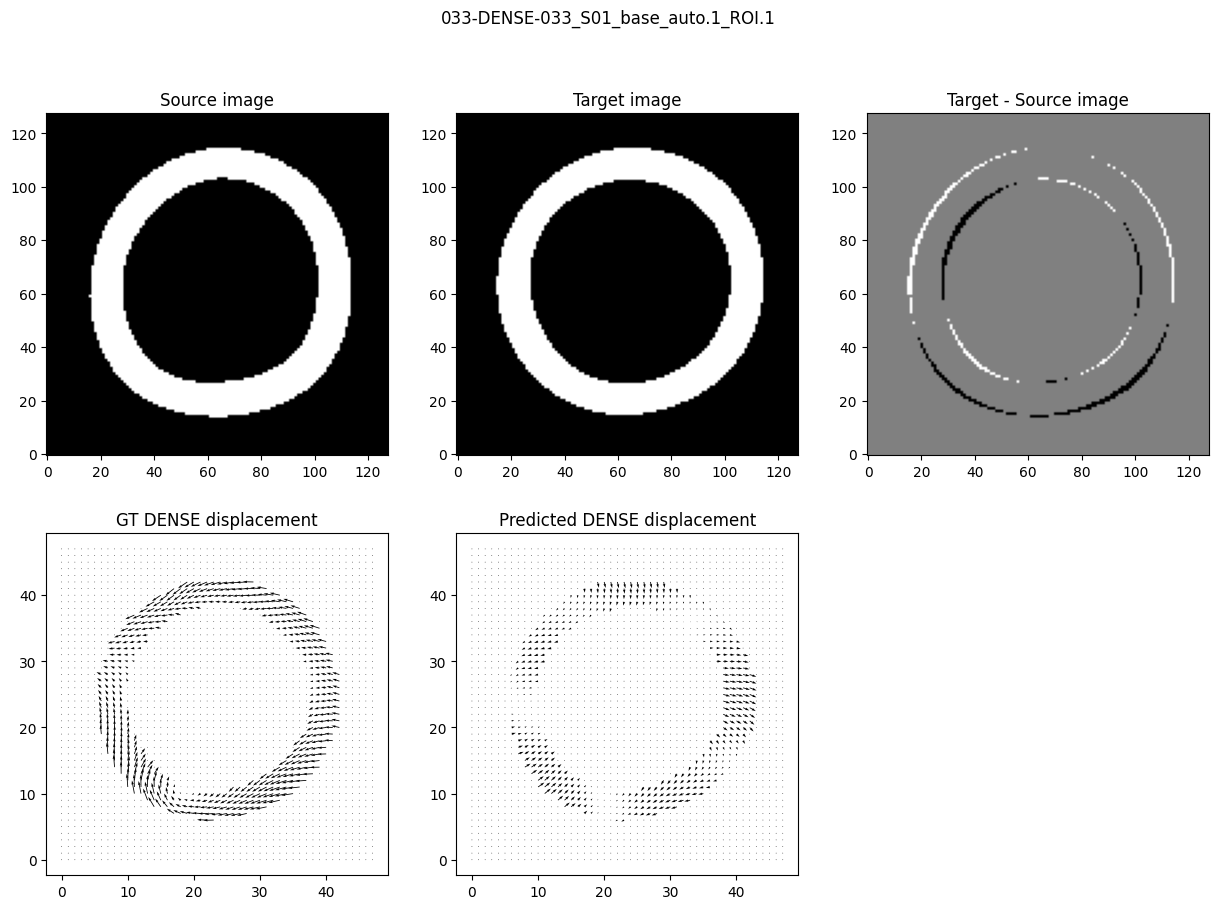

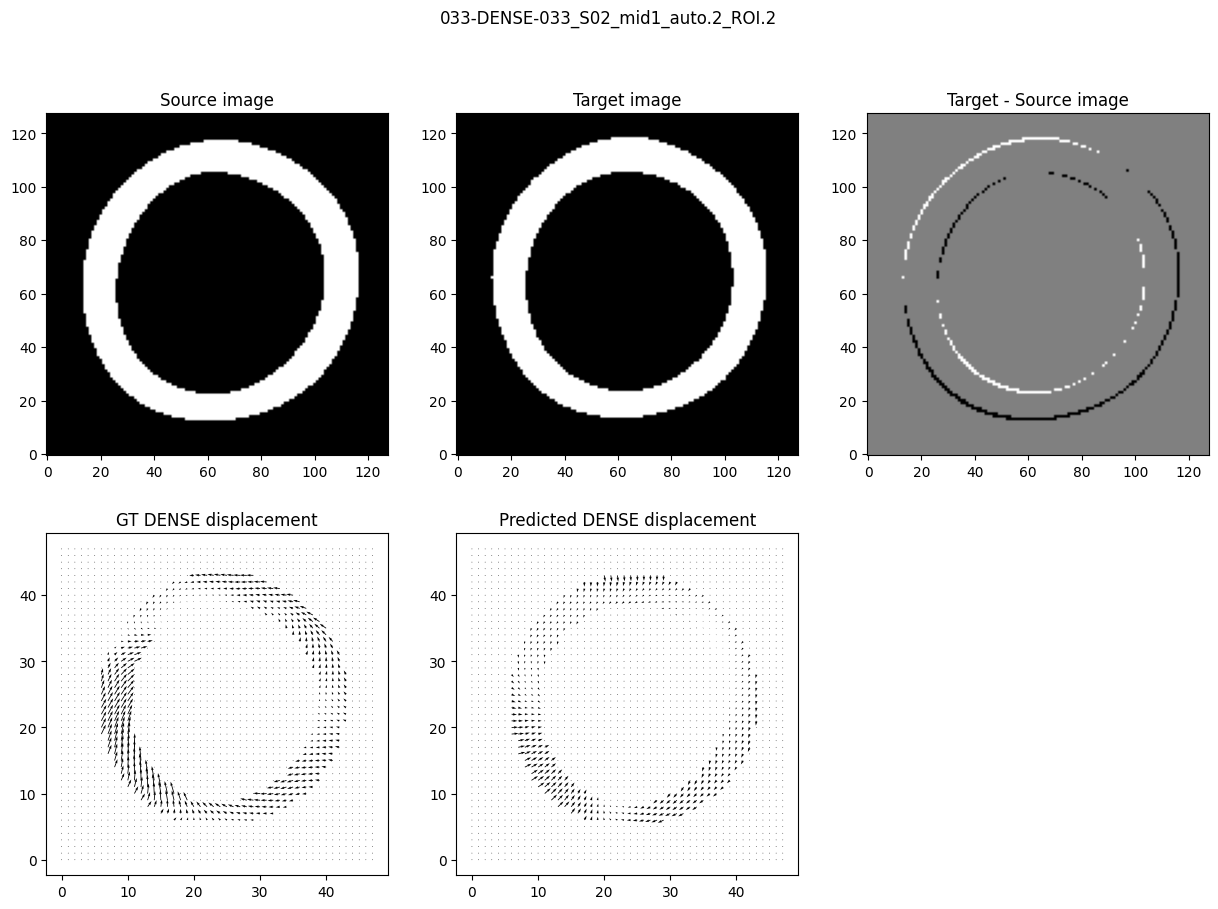

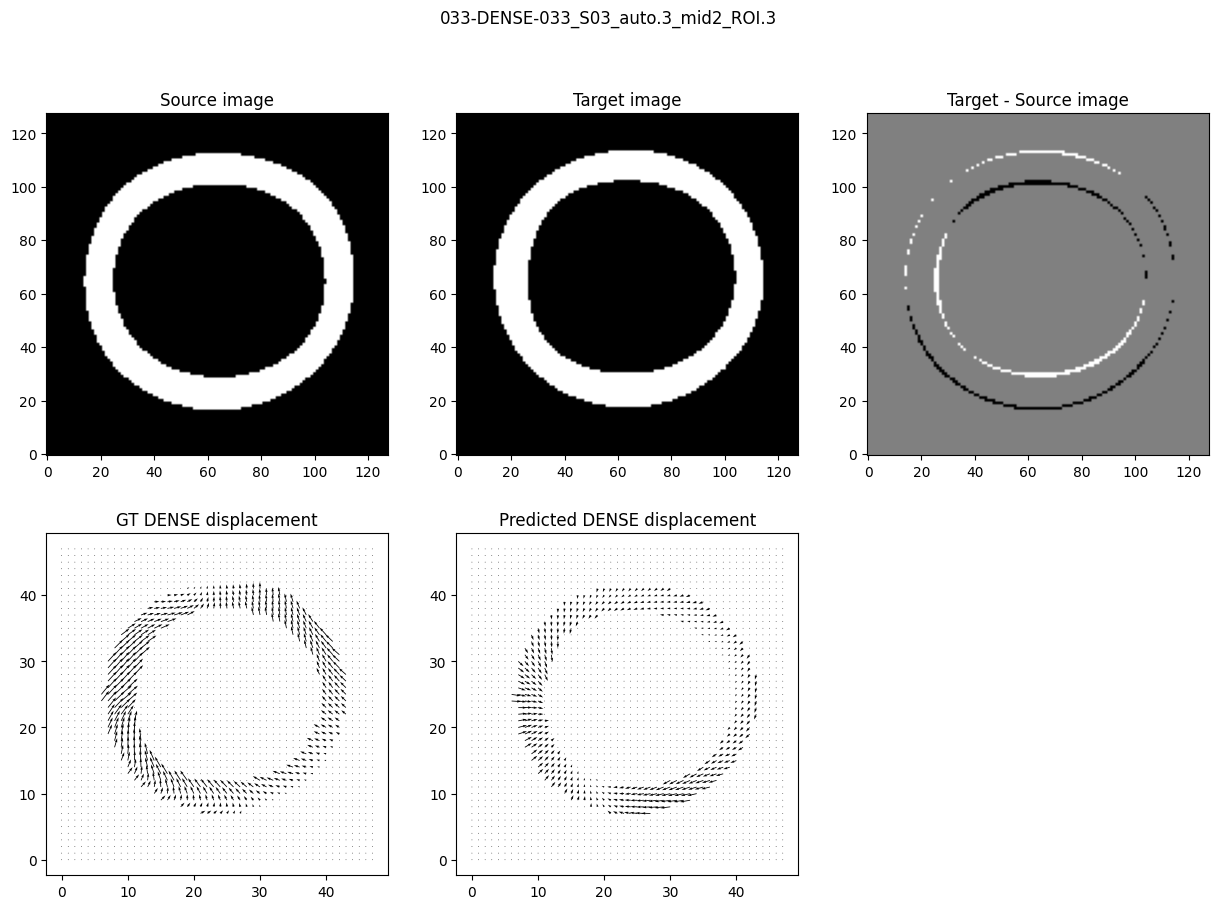

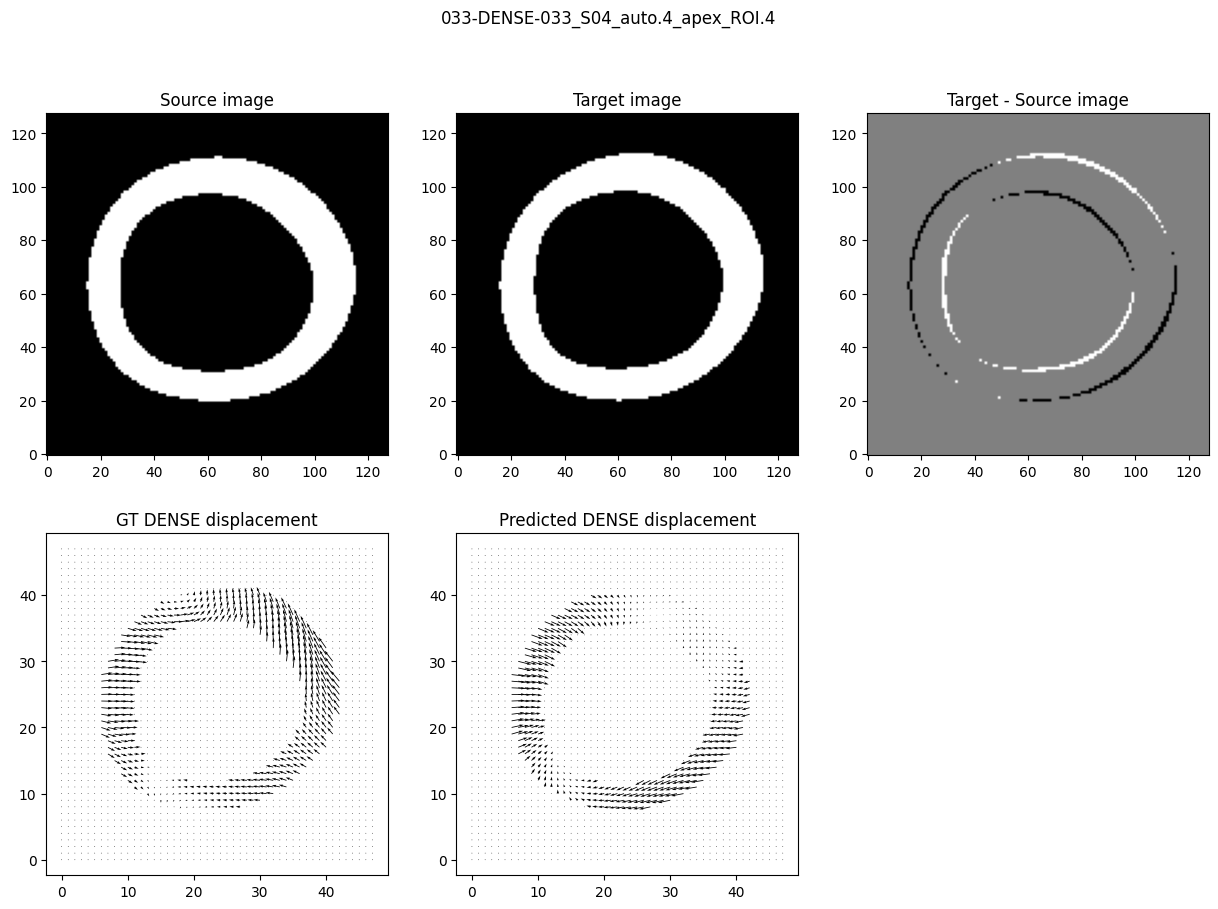

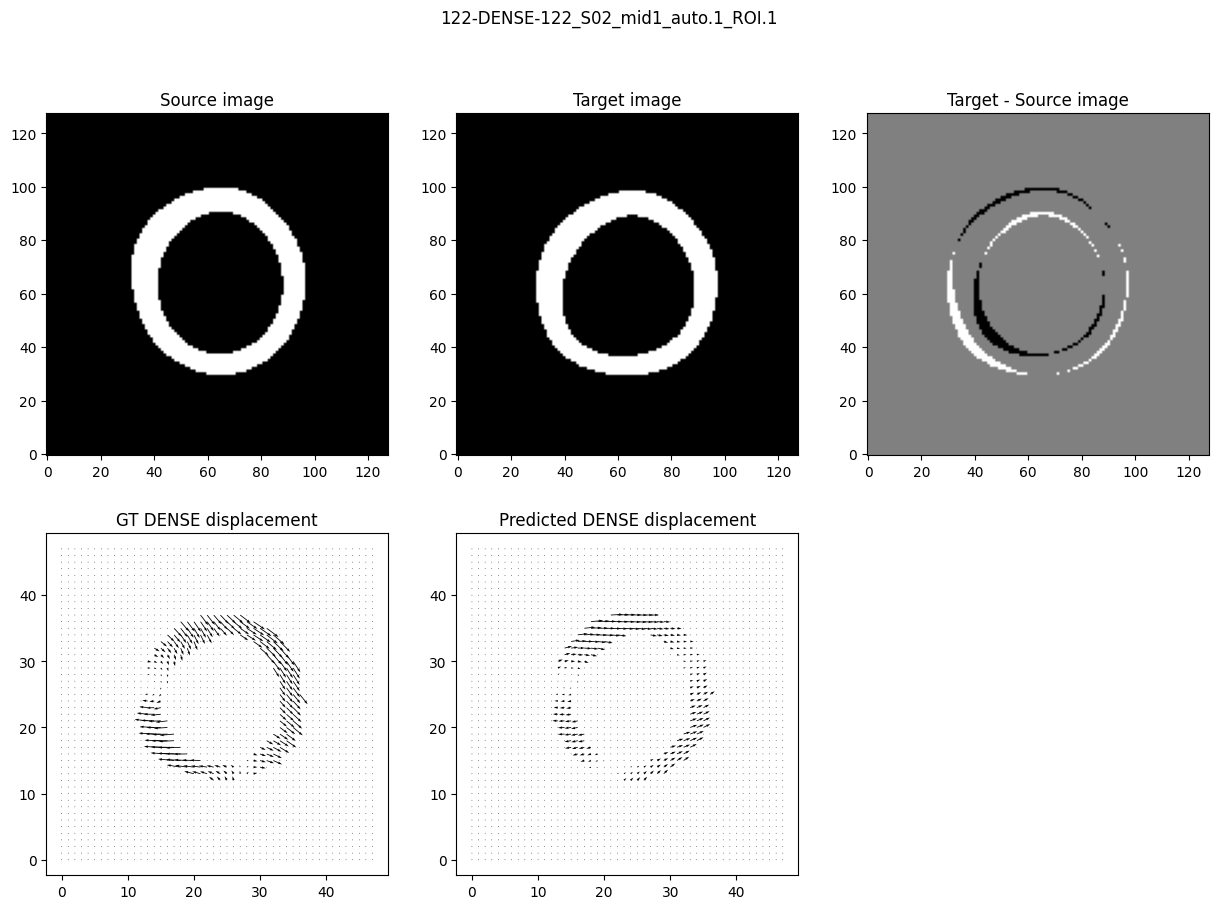

In [19]:
trainer.plot_results(test_pred, 
                     save_fig_dir='./test_results', 
                     save_plot=False, 
                     n_plot_patients = 2,
                     DENSE_quiver_scale=1,
                     reg_quiver_scale=1)

In [23]:
# save val and test predictions as npy file
import numpy as np
from pathlib import Path

saving_dir = Path(config['saving'].get('saving_dir', './test_results'))
saving_dir.mkdir(parents=True, exist_ok=True)

print('experiment results saving dir: ', saving_dir)

data_keys_to_pop = config['saving'].get('data_keys_to_pop', [])
for test_datum in test_pred:
    for key in data_keys_to_pop:
        if key in test_datum.keys():
            test_datum.pop(key)

# val_save_filename = config['saving'].get('val_save_filename', 'val_pred.npy')
test_save_filename = config['saving'].get('test_save_filename', 'test_pred.npy')
# np.save(Path(saving_dir, val_save_filename), val_pred)
np.save(Path(saving_dir, test_save_filename), test_pred)

experiment results saving dir:  test_results
